# Testing for the 1DInt Method For Diploids and Auotetraploids

In [1]:
import numpy as np
import dadi 
from matplotlib import pyplot as plt
import dadi.Polyploids.Integration as PolyInt
from dadi.Polyploids import wrightfisher as WF
from dadi.Polyploids import kimura_analytic
import time

## Test Accuracy of the Int1D Integration for Diploids against dadi
Here, we want to ensure that the results from the Int1D integration are the same as the results from dadi.

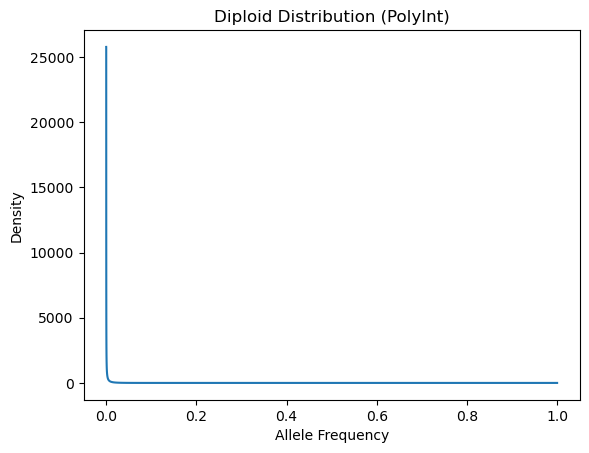

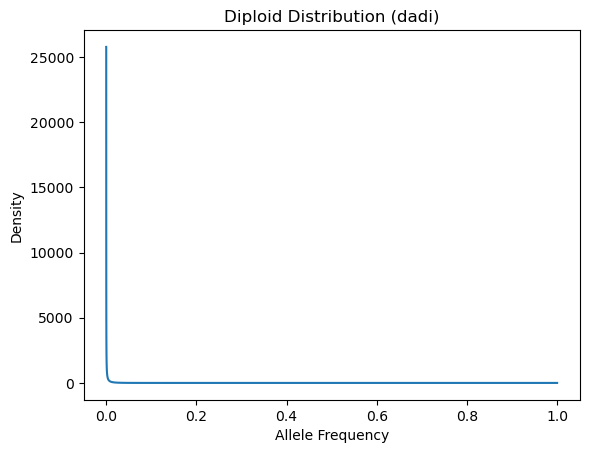

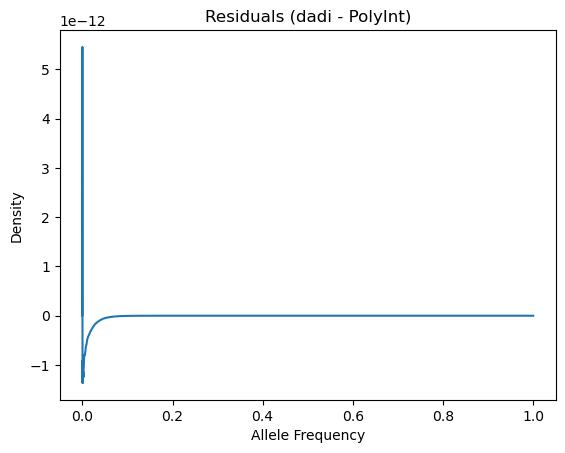

In [2]:
xx = dadi.Numerics.default_grid(pts=101)

phi = dadi.PhiManip.phi_1D(xx)

ploidyflag = PolyInt.PloidyType.DIPLOID
T = 10
gamma = -10
h = 0.75
sel_dict = {'gamma': gamma, 'h': h}
nu = 1.5
nu_func = lambda t: np.exp(np.log(nu)*t/T)

phi_poly = PolyInt.one_pop(phi, xx, T=T, ploidyflag=ploidyflag, sel_dict=sel_dict, theta0=1, nu=nu_func)

plt.plot(xx, phi_poly)
plt.xlabel('Allele Frequency')
plt.ylabel('Density')
plt.title('Diploid Distribution (PolyInt)')
plt.show()

phi_dadi = dadi.Integration.one_pop(phi, xx, T=T, theta0=1, gamma=gamma, h=h, nu=nu_func)

plt.plot(xx, phi_dadi)
plt.xlabel('Allele Frequency')
plt.ylabel('Density')
plt.title('Diploid Distribution (dadi)')
plt.show()

plt.plot(xx, phi_dadi - phi_poly)
plt.xlabel('Allele Frequency')
plt.ylabel('Density')
plt.title('Residuals (dadi - PolyInt)')
plt.show()

## Test Accuracy of PolyInt for Autotetraploids against WF Simulations
Note that the WF simulations require constant params. To test PolyInt's Cython implementation, we will need to bypass the const_params Python integration. To do this, I added a bypass_const_params option to the integrators. We will want to remove this option later.

Mean final allele frequency: 0.06832354410295587
Variance of final allele frequency: 0.005274467640274734


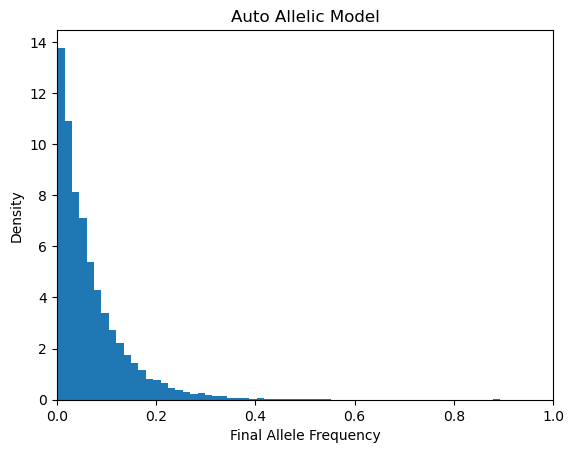

Mean: 0.06695649222978037
Variance: 0.0050596116303285405


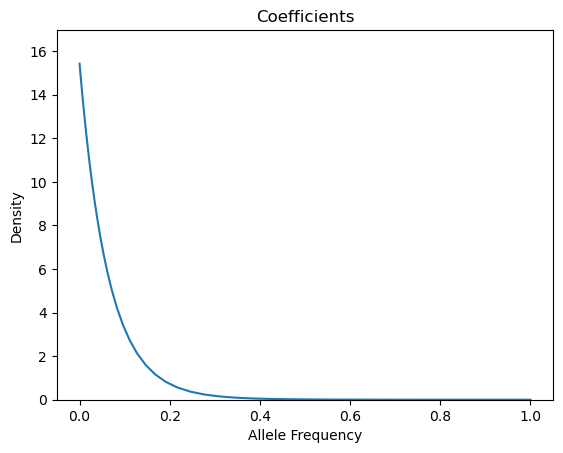

Mean: 0.06695649222978044
Variance: 0.005059611630328569


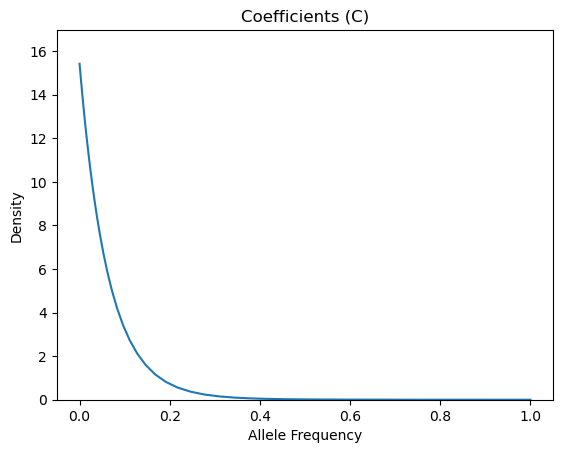

Mean: 0.06695649222978037
Variance: 0.0050596116303285405


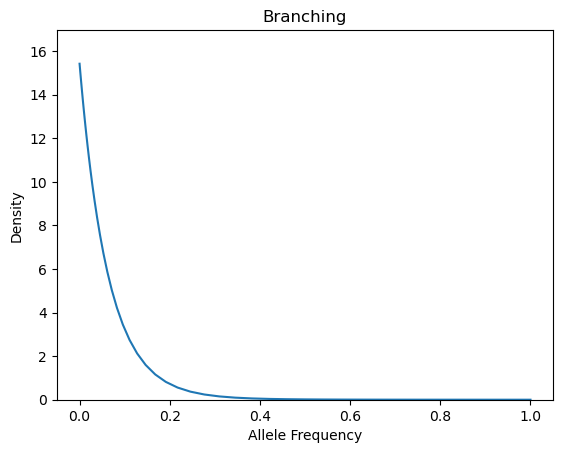

Mean: 0.06695649222978044
Variance: 0.005059611630328569


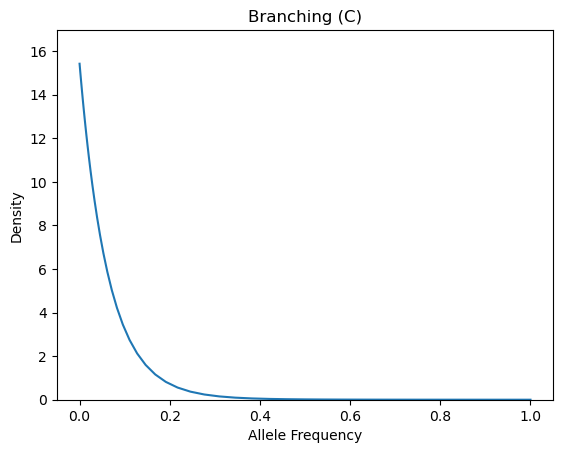

In [ ]:
# Test Autotetraploid Integrations Against WF Model
# set up parameters, grid, and phi
xx = dadi.Numerics.default_grid(pts=101)
# Dirac delta type phi
phi = np.zeros_like(xx)
phi[50] = 1

T = 1
gamma = -10

ploidyflag = PolyInt.PloidyType.AUTO
sel_dict = {'gamma1': gamma/4, 'gamma2': gamma/2, 'gamma3': 3*gamma/4, 'gamma4': gamma}
sel=ploidyflag.pack_sel_params(sel_dict)

# WF MODEL
WF_auto = WF.auto_allelic_WF(N=1000, T=T, gamma1=sel[0], gamma2=sel[1], gamma3=sel[2], gamma4=sel[3], init_q = np.full(100000, .5), replicates = 100000)
# extract final frequencies and mask/remove 0 and 1 entries
allele_polymorphic = WF.mask(WF_auto)

# Compute and print mean and variance
print(f"Mean final allele frequency: {np.mean(allele_polymorphic)}")
print(f"Variance of final allele frequency: {np.var(allele_polymorphic)}")

# Plot histogram of final allele frequencies
plt.hist(allele_polymorphic, bins = 60, density = True)
plt.xlabel('Final Allele Frequency')
plt.ylabel('Density')
plt.title('Auto Allelic Model')
plt.xlim(0, 1)
plt.show()

# DADI DIFFUSION MODELS
coeff_python = PolyInt.one_pop(phi, xx, T=T, ploidyflag=ploidyflag, sel_dict=sel_dict, theta0=0)
coeff_c = PolyInt.one_pop(phi, xx, T=T, ploidyflag=ploidyflag, sel_dict=sel_dict, theta0=0, bypass_const_params=True)

branch_python = PolyInt.one_pop_branching(phi, xx, T=T, ploidyflag=ploidyflag, sel_dict=sel_dict, theta0=0)
branch_c = PolyInt.one_pop_branching(phi, xx, T=T, ploidyflag=ploidyflag, sel_dict=sel_dict, theta0=0, bypass_const_params=True)

# plot and print mean and variance
WF.summarize_phi(coeff_python, xx, 'Coefficients')
WF.summarize_phi(coeff_c, xx, 'Coefficients (C)')
WF.summarize_phi(branch_python, xx, 'Branching')
WF.summarize_phi(branch_c, xx, 'Branching (C)')



## Benchmarking the performance of the Int1D model
Test performance (time) of the Int1D model with coeffs vs. branching outside the inner loop.

### First, we will test PolyInt vs. dadi for Constant Params
This version will call the Python integrator for constant parameters and does not use much C or Cython (other than for tridiag).

(0.0, 0.11225355793721974)

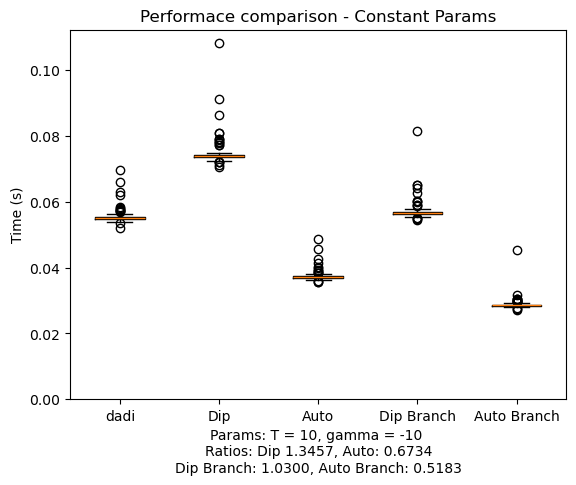

In [3]:
# Benchmarking - Constant Params, Both Coefficient and Branching Methods
xx = dadi.Numerics.default_grid(pts=101)

phi = dadi.PhiManip.phi_1D(xx)

ploidyflag = PolyInt.PloidyType.DIPLOID
ploidyflag_auto = PolyInt.PloidyType.AUTO
T = 10
gamma = -10
h = 0.5
sel_dict = {'gamma': gamma, 'h': h}
sel_dict_auto = {'gamma1': gamma/4, 'gamma2': gamma/2, 'gamma3':3*gamma/4, 'gamma4':gamma} # need to create a wrapper for this
iterations = 100

dadi_perf = np.empty(iterations)
poly_perf = np.empty(iterations)
poly_auto_perf = np.empty(iterations)
poly_perf_branch = np.empty(iterations)
poly_auto_perf_branch = np.empty(iterations)
for i in range(iterations):
    start = time.perf_counter()
    phi_dadi = dadi.Integration.one_pop(phi, xx, T=T, theta0=1, gamma=gamma, h=h)
    end = time.perf_counter()
    dadi_perf[i] = end - start

    start = time.perf_counter()
    phi_poly = PolyInt.one_pop(phi, xx, T=T, ploidyflag=ploidyflag, sel_dict=sel_dict, theta0=1)
    end = time.perf_counter()
    poly_perf[i] = end - start

    start = time.perf_counter()
    phi_poly_auto = PolyInt.one_pop(phi, xx, T=T, ploidyflag=ploidyflag_auto, sel_dict=sel_dict_auto, theta0=1)
    end = time.perf_counter()
    poly_auto_perf[i] = end - start

    start = time.perf_counter()
    phi_poly_branch = PolyInt.one_pop_branching(phi, xx, T=T, ploidyflag=ploidyflag, sel_dict=sel_dict, theta0=1)
    end = time.perf_counter()
    poly_perf_branch[i] = end - start

    start = time.perf_counter()
    phi_poly_auto_branch = PolyInt.one_pop_branching(phi, xx, T=T, ploidyflag=ploidyflag_auto, sel_dict=sel_dict_auto, theta0=1)
    end = time.perf_counter()
    poly_auto_perf_branch[i] = end - start

# Plot boxplot of performance
performance = [dadi_perf, poly_perf, poly_auto_perf, poly_perf_branch, poly_auto_perf_branch]

ratio_dip = np.mean(poly_perf)/np.mean(dadi_perf)
ratio_auto = np.mean(poly_auto_perf)/np.mean(dadi_perf)
ratio_dip_branch = np.mean(poly_perf_branch)/np.mean(dadi_perf)
ratio_auto_branch = np.mean(poly_auto_perf_branch)/np.mean(dadi_perf)

plt.boxplot(performance, tick_labels=['dadi', 'Dip', 'Auto', 'Dip Branch', 'Auto Branch'])
plt.title("Performace comparison - Constant Params")
plt.ylabel("Time (s)")
plt.xlabel(
    f"Params: T = {T}, gamma = {gamma} \n"
    f"Ratios: Dip {ratio_dip:.4f}, Auto: {ratio_auto:.4f}\n"
    f"Dip Branch: {ratio_dip_branch:.4f}, Auto Branch: {ratio_auto_branch:.4f}"
)
plt.ylim(ymin=0)


### Then, we will test PolyInt vs. dadi for Variable Nu 
This will call the C and Cython integration functions.

(0.0, 0.29410428162664176)

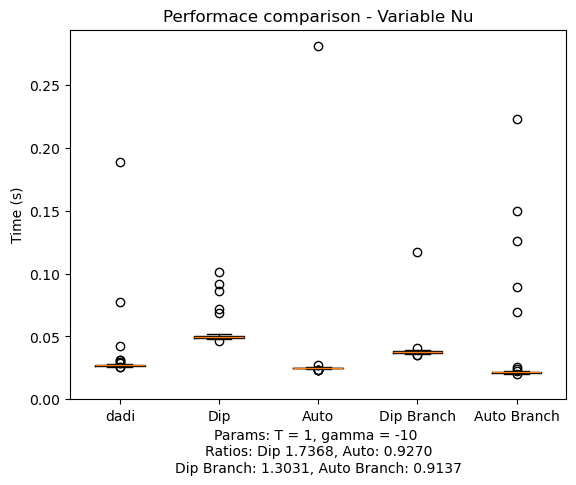

In [ ]:
# Benchmarking - Variable Params, Both Coefficient and Branching Methods
xx = dadi.Numerics.default_grid(pts=101)

phi = dadi.PhiManip.phi_1D(xx)

ploidyflag = PolyInt.PloidyType.DIPLOID
ploidyflag_auto = PolyInt.PloidyType.AUTO
T = 1
gamma = -10
h = 0.5
sel_dict = {'gamma': gamma, 'h': h}
sel_dict_auto = {'gamma1': gamma/4, 'gamma2': gamma/2, 'gamma3':3*gamma/4, 'gamma4':gamma} # need to create a wrapper for this
iterations = 100
nu = 1.5
nu_func = lambda t: np.exp(np.log(nu)*t/T)

dadi_perf = np.empty(iterations)
poly_perf = np.empty(iterations)
poly_auto_perf = np.empty(iterations)
poly_perf_branch = np.empty(iterations)
poly_auto_perf_branch = np.empty(iterations)
for i in range(iterations):
    start = time.perf_counter()
    phi_dadi = dadi.Integration.one_pop(phi, xx, T=T, theta0=1, gamma=gamma, h=h, nu=nu_func)
    end = time.perf_counter()
    dadi_perf[i] = end - start

    start = time.perf_counter()
    phi_poly = PolyInt.one_pop(phi, xx, T=T, ploidyflag=ploidyflag, sel_dict=sel_dict, theta0=1, nu=nu_func)
    end = time.perf_counter()
    poly_perf[i] = end - start

    start = time.perf_counter()
    phi_poly_auto = PolyInt.one_pop(phi, xx, T=T, ploidyflag=ploidyflag_auto, sel_dict=sel_dict_auto, theta0=1, nu=nu_func)
    end = time.perf_counter()
    poly_auto_perf[i] = end - start

    start = time.perf_counter()
    phi_poly_branch = PolyInt.one_pop_branching(phi, xx, T=T, ploidyflag=ploidyflag, sel_dict=sel_dict, theta0=1, nu=nu_func)
    end = time.perf_counter()
    poly_perf_branch[i] = end - start

    start = time.perf_counter()
    phi_poly_auto = PolyInt.one_pop_branching(phi, xx, T=T, ploidyflag=ploidyflag_auto, sel_dict=sel_dict_auto, theta0=1, nu=nu_func)
    end = time.perf_counter()
    poly_auto_perf_branch[i] = end - start

# Plot boxplot of performance
performance = [dadi_perf, poly_perf, poly_auto_perf, poly_perf_branch, poly_auto_perf_branch]

ratio_dip = np.mean(poly_perf)/np.mean(dadi_perf)
ratio_auto = np.mean(poly_auto_perf)/np.mean(dadi_perf)
ratio_dip_branch = np.mean(poly_perf_branch)/np.mean(dadi_perf)
ratio_auto_branch = np.mean(poly_auto_perf_branch)/np.mean(dadi_perf)

plt.boxplot(performance, tick_labels=['dadi', 'Dip', 'Auto', 'Dip Branch', 'Auto Branch'])
plt.title("Performace comparison - Variable Nu")
plt.ylabel("Time (s)")
plt.xlabel(
    f"Params: T = {T}, gamma = {gamma} \n"
    f"Ratios: Dip {ratio_dip:.4f}, Auto: {ratio_auto:.4f}\n"
    f"Dip Branch: {ratio_dip_branch:.4f}, Auto Branch: {ratio_auto_branch:.4f}"
)
plt.ylim(ymin=0)

### Now, let's see how things compare for large gammas where the timestep may be small

(0.0, 3.8206732000107877)

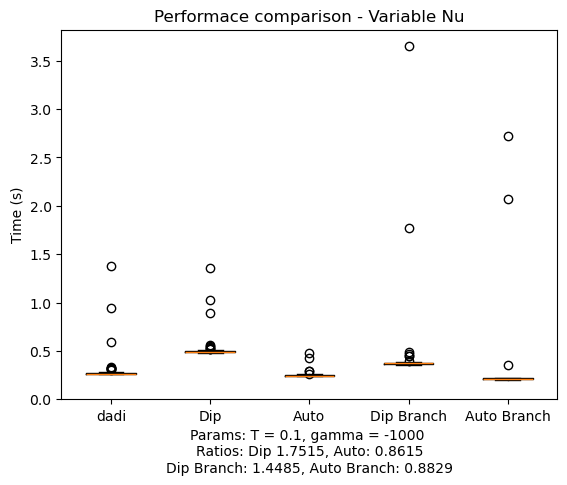

In [16]:
# Benchmarking - Variable Params, Both Coefficient and Branching Methods
xx = dadi.Numerics.default_grid(pts=101)

phi = dadi.PhiManip.phi_1D(xx)

ploidyflag = PolyInt.PloidyType.DIPLOID
ploidyflag_auto = PolyInt.PloidyType.AUTO
T = .1
gamma = -1000
h = 0.5
sel_dict = {'gamma': gamma, 'h': h}
sel_dict_auto = {'gamma1': gamma/4, 'gamma2': gamma/2, 'gamma3':3*gamma/4, 'gamma4':gamma} # need to create a wrapper for this
iterations = 100
nu = 1.5
nu_func = lambda t: np.exp(np.log(nu)*t/T)

dadi_perf = np.empty(iterations)
poly_perf = np.empty(iterations)
poly_auto_perf = np.empty(iterations)
poly_perf_branch = np.empty(iterations)
poly_auto_perf_branch = np.empty(iterations)
for i in range(iterations):
    start = time.perf_counter()
    phi_dadi = dadi.Integration.one_pop(phi, xx, T=T, theta0=1, gamma=gamma, h=h, nu=nu_func)
    end = time.perf_counter()
    dadi_perf[i] = end - start

    start = time.perf_counter()
    phi_poly = PolyInt.one_pop(phi, xx, T=T, ploidyflag=ploidyflag, sel_dict=sel_dict, theta0=1, nu=nu_func)
    end = time.perf_counter()
    poly_perf[i] = end - start

    start = time.perf_counter()
    phi_poly_auto = PolyInt.one_pop(phi, xx, T=T, ploidyflag=ploidyflag_auto, sel_dict=sel_dict_auto, theta0=1, nu=nu_func)
    end = time.perf_counter()
    poly_auto_perf[i] = end - start

    start = time.perf_counter()
    phi_poly_branch = PolyInt.one_pop_branching(phi, xx, T=T, ploidyflag=ploidyflag, sel_dict=sel_dict, theta0=1, nu=nu_func)
    end = time.perf_counter()
    poly_perf_branch[i] = end - start

    start = time.perf_counter()
    phi_poly_auto = PolyInt.one_pop_branching(phi, xx, T=T, ploidyflag=ploidyflag_auto, sel_dict=sel_dict_auto, theta0=1, nu=nu_func)
    end = time.perf_counter()
    poly_auto_perf_branch[i] = end - start

# Plot boxplot of performance
performance = [dadi_perf, poly_perf, poly_auto_perf, poly_perf_branch, poly_auto_perf_branch]

ratio_dip = np.mean(poly_perf)/np.mean(dadi_perf)
ratio_auto = np.mean(poly_auto_perf)/np.mean(dadi_perf)
ratio_dip_branch = np.mean(poly_perf_branch)/np.mean(dadi_perf)
ratio_auto_branch = np.mean(poly_auto_perf_branch)/np.mean(dadi_perf)

plt.boxplot(performance, tick_labels=['dadi', 'Dip', 'Auto', 'Dip Branch', 'Auto Branch'])
plt.title("Performace comparison - Variable Nu")
plt.ylabel("Time (s)")
plt.xlabel(
    f"Params: T = {T}, gamma = {gamma} \n"
    f"Ratios: Dip {ratio_dip:.4f}, Auto: {ratio_auto:.4f}\n"
    f"Dip Branch: {ratio_dip_branch:.4f}, Auto Branch: {ratio_auto_branch:.4f}"
)
plt.ylim(ymin=0)

### Let's try to see where the bottlenecks might be for the polyploid integration
An obvious first place to look are the M func computations and compute_dt functions.

The compute_dt function cannot be optimized too much, but using Horner's method for the M func improved the ratio from ~2.15 to ~1.55, which is significant. 

In [11]:
xx = dadi.Numerics.default_grid(pts=101)
dx = np.diff(xx)

phi = dadi.PhiManip.phi_1D(xx)

gamma = -10
h = 0.5
gam1 = gamma/4
gam2 = gamma/2
gam3 = 3*gamma/4
gam4 = gamma
nu = 1.
ms = [0]

iterations = 100000

M_dip = np.empty(iterations)
M_auto = np.empty(iterations)
dt_dip = np.empty(iterations)
dt_auto = np.empty(iterations)

for i in range(iterations):
    start = time.perf_counter()
    M_val = PolyInt._Mfunc1D(xx, gamma, h)
    end = time.perf_counter()
    M_dip[i] = end - start

    start = time.perf_counter()
    dt_val = PolyInt._compute_dt(dx, nu, ms, gamma, h)
    end = time.perf_counter()
    dt_dip[i] = end - start

    start = time.perf_counter()
    M_val = PolyInt._Mfunc1D_auto(xx, gam1, gam2, gam3, gam4)
    end = time.perf_counter()
    M_auto[i] = end - start

    start = time.perf_counter()
    dt_val = PolyInt._compute_dt_auto(dx, nu, ms, gam1, gam2, gam3, gam4)
    end = time.perf_counter()
    dt_auto[i] = end - start


print(f"Diploid M avg.: {np.mean(M_dip)} \n" 
      f"Auto M avg.: {np.mean(M_auto)} \n"
      f"M Ratio: {np.mean(M_auto)/np.mean(M_dip)}")

print(f"Diploid dt avg.: {np.mean(dt_dip)} \n" 
      f"Auto dt avg.: {np.mean(dt_auto)} \n"
      f"dt Ratio: {np.mean(dt_auto)/np.mean(dt_dip)}")


Diploid M avg.: 2.82934220158495e-06 
Auto M avg.: 4.421484087361023e-06 
M Ratio: 1.5627251044020696
Diploid dt avg.: 1.427371861645952e-06 
Auto dt avg.: 2.3451680946163834e-06 
dt Ratio: 1.6429972858734154


## Example Usage of PloidyType Class
Simple walkthrough of how to use the PloidyType class to specify a population's ploidy type.

In [9]:
ploidyflag = PolyInt.PloidyType.DIPLOID
print(ploidyflag)
print(ploidyflag.value)

ploidyflag2 = PolyInt.PloidyType.AUTO
print(ploidyflag2)
print(ploidyflag2.value)


PloidyType.DIPLOID
0
PloidyType.AUTO
1


In [12]:
# Then, to specify the ploidy of a population we simply write
# diploids
ploidy = np.zeros(2, dtype=np.intc)
ploidy[ploidyflag] = 1
print(ploidy)
# autotetraploids
ploidy2 = np.zeros(2, dtype=np.intc)
ploidy2[ploidyflag2] = 1
print(ploidy2)


[1 0]
[0 1]


In [ ]:
sel_dict = {'gamma': -4, 'h': 0.5}
sel_dict2 = {'gamma1': -1, 'gamma2': -2, 'gamma3': -3, 'gamma4': -4}

# Note: I still need to add wrappers for additive selection models 
# which take a single gamma for the autos
# I also need to add warnings for the pack_sel_params function if 
# the user inputs an incompatible sel_dict
# but, setting up the sel_dict is pretty straightforward
sel = ploidyflag.pack_sel_params(sel_dict)
sel2 = ploidyflag2.pack_sel_params(sel_dict2)

print(sel)
print(sel2)
# Note: the vectors are longer because we need to support 
# allotetraploids without changing the length of the vector
# So, for Justin's allohexaploids, sel would be of length 26

[-4, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[-1, -2, -3, -4, 0.0, 0.0, 0.0, 0.0]
